In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.ffd import FFD

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [2]:
df = pd.read_csv("../flare_tables/20200218_vetted_flares.csv",
                names=['ampl_rec','cstart','cstop','ed_rec','ed_rec_err',
                    'istart', 'istop','total_n_valid_data_points', 
                    'tstart', 'tstop',  'dur', 'ed_ratio','ed_ratio_count',
            'amplitude_ratio','amplitude_ratio_count','duration_ratio','duration_ratio_count',
            'amplitude_corr','duration_corr','ed_corr','recovery_probability','recovery_probability_count',
            'ed_ratio_std','amplitude_ratio_std','duration_ratio_std','recovery_probability_std',
            'ed_corr_err','amplitude_corr_err','duration_corr_err',"TIC","sector"])
              
#spts = pd.read_csv("../flare_tables/spts.csv")

#spts.head()
#df = df.merge(spts[["TIC","spt","TESSmag"]],on="TIC")
df.head()

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop,...,recovery_probability_count,ed_ratio_std,amplitude_ratio_std,duration_ratio_std,recovery_probability_std,ed_corr_err,amplitude_corr_err,duration_corr_err,TIC,sector
0,0.054356,119297,119306,35.835830,1.763268,4923,4932,12835.0,1393.151454,1393.163954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.101038,152637,152644,30.406816,1.828507,586,593,16349.0,1439.452361,1439.462083,...,33.0,0.124723,0.135370,0.292849,0.331434,7.910980,0.017503,0.005243,NaN,NaN
2,0.018912,159470,159473,5.704301,0.547990,7393,7396,16349.0,1448.940559,1448.944725,...,34.0,0.128436,0.145729,0.256401,0.507519,2.038336,0.003150,0.004284,NaN,NaN
3,0.028682,164325,164340,28.611778,0.814129,10837,10852,16349.0,1455.683582,1455.704416,...,26.0,0.093004,0.093889,0.272593,0.000000,5.385723,0.003042,0.008833,NaN,NaN
4,0.028935,167643,167655,20.634373,0.626127,14148,14160,16349.0,1460.291909,1460.308576,...,33.0,0.093004,0.093889,0.272593,0.000000,3.890185,0.003069,0.007066,NaN,NaN


In [ ]:
totobs = df.groupby(["TIC","sector"]).total_n_valid_data_points.apply(lambda x: x.iloc[0]).sum()/30./24./365.25

In [ ]:
totobs

In [ ]:
plt.hist(df.recovery_probability_count, bins=np.linspace(0,50,10), histtype="step");

In [ ]:
plt.hist(df.ed_ratio_count, bins=np.linspace(0,50,10), histtype="step");

In [ ]:
plt.scatter(df.ampl_rec, df.amplitude_corr)
plt.plot([0,12],[0,12])

In [ ]:
plt.hist(df.amplitude_ratio_count, bins=np.linspace(0,300,10), histtype="step");

In [ ]:
plt.hist(df.duration_ratio_count, bins=np.linspace(0,300,10), histtype="step");

In [ ]:
plt.scatter(df.ed_rec, df.ed_corr)
plt.plot([1,3e3],[1,3e3])
plt.yscale("log")
plt.xscale("log")

In [ ]:
plt.hist(df.recovery_probability, bins=np.linspace(0,1,6), histtype="step");

In [ ]:
#correct for magnitudes
plt.figure(figsize=(6.5,5.5))
plt.hist(df.TESSmag, bins=20);


In [ ]:
df[df.TESSmag>10].TESSmag.hist()

### FFDs


#### plots

- one star
- multiple stars

#### modes

- corrected for energy
- corrected for energy and recovery probability
- uncorrected


#### functions

- fit powerlaw
- fit beta

#### attributes

- dataframe a la flc.flares
- alpha, beta, and errors


### Not included

- cutoff recovery probability
- cutoff energy

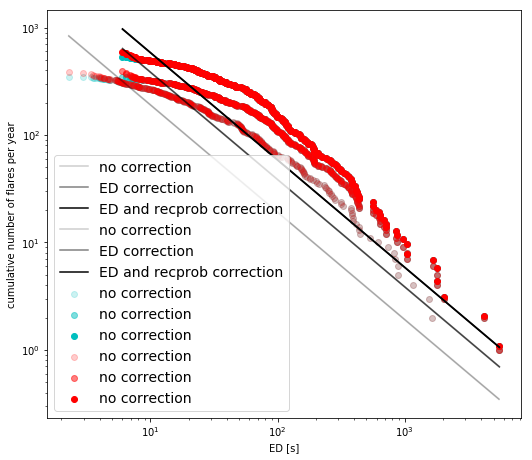

In [3]:
df["TIC"] = np.arange(df.shape[0])%13
df = df[~np.isnan(df.recovery_probability) & (df.recovery_probability > 0.2)]
df = df.sort_values(by="ed_corr", ascending=False)
df = df[~df.ed_corr.isnull() & np.isfinite(df.ed_corr) & (df.ed_corr > 6)]

ffd = FFD(df,ID="TIC")
ffd.alpha, ffd.alpha_err = 2., .2
ffd.tot_obs_time = 1.

fig, ax = plt.subplots(1,figsize=(8.5,7.5))

# No correction, single star mode
ed, freq = ffd.ed_and_freq( energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c", label="no correction",alpha=.2)
_beta, ffd.beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k", alpha=.2, label="no correction")

# ED correction, single star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c", label="no correction",alpha=.5)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=.5, label="ED correction")


# ED and recprob correction, single star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c",alpha=1, label="no correction")
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=1, label="ED and recprob correction")




# No correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r", label="no correction",alpha=.2)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k", alpha=.2, label="no correction")

# ED correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=False,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r", label="no correction",alpha=.5)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=.5, label="ED correction")


# ED and recprob correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r",alpha=1, label="no correction")
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=1, label="ED and recprob correction")


plt.xscale('log')
plt.yscale('log')
plt.xlabel("ED [s]")#"flare energy in TESS band [erg]")
plt.ylabel("cumulative number of flares per year")
# #plt.title(spt)
plt.legend(fontsize=14)
# #     plt.figure(figsize=(6.5,5.5))
# #     plt.hist(df.TESSmag)
# #     plt.title(spt)

# plt.ylim(.1,1e3)
# plt.xlim(1,10000)
# # for x,z in zip(a,f):
# #     print(x,z)
# # print(df.shape)
# plt.savefig(f"../plots/{tstamp}_FFD_two_step_correction.png".format(tstamp), dpi=300)

In [7]:
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
ffd.is_powerlaw(ed),  ffd.is_powerlaw_truncated(ed)

/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/notebook/funcs/ffd.py:248: UserWarning: Kolmogorov-Smirnov tells us to reject the power law hypothesis at p=0.05. KS=0.3869318583646213, limit=0.0730119898114961
  ' KS={}, limit={}'.format(sig_level, KS, limit))


(False, False)

In [ ]:
#df = df[df.recovery_probability > .2]


df = df.sort_values(by="ed_rec", ascending=False)
#df['probnocorrcum'] = np.cumsum(1/np.array(freq[::-1])*freq[-1])
df['probnocorrcum'] = np.cumsum(np.ones_like(freq))
df['sortededrec'] =df.ed_rec.sort_values(ascending=False)
df = df.sort_values(by="ed_corr", ascending=False)
df = df[(~df.ed_corr.isnull()) & (np.isfinite(df.ed_corr)) & (df.recovery_probability >0.0) ]
df["ed_corrprob"] = 1/df.recovery_probability.values
df["ed_corrprob_err"] = df.recovery_probability_std / df.recovery_probability**2
df["ed_corrprobcum"] = np.cumsum(df.ed_corrprob.values)


plt.figure(figsize=(6.5,5.5))
for l, row in df.iterrows():
    plt.plot([row.sortededrec, row.ed_corr], [row.probnocorrcum, row.ed_corrprobcum],c="grey",alpha=.5)
plt.scatter(df["sortededrec"], df["probnocorrcum"], label="no correction", c="k")#, condition {}".format(label))
plt.scatter(df.ed_corr, df["ed_corrprobcum"], label="energy ratio and recovery probability correction", c="r")#, condition {}".format(label))
plt.plot([10, 4000],[4000, 10], label="slope=-1", linestyle="dashed", c="grey", linewidth=3)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(.8,250)
#plt.xlim(5,4000)
plt.xlabel("ED [s]")#"flare energy in TESS band [erg]")
plt.ylabel("cumulative number of flares")
plt.legend()
#plt.savefig("plots/{}_FFD_flare_correspondence_correction.png".format(today), dpi=300)

In [ ]:
f
